In [1]:
import os 
import glob
import pandas as pd 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from difflib import ndiff
import spacy
from collections import defaultdict
from tqdm.auto import tqdm
import difflib
from IPython.display import display, HTML
plt.rc('font', size=14)
from importlib import reload
import sys
sys.path.insert(0, '..')
import util.util_newssniffer_parsing as up

# Process Data from Different Sources

In [104]:
#  v1 diffs
## read in small article files and "diff" files

## get filepaths
cache_dir = '../scraping/scrapy-cloud/output_dir/'
files = glob.glob(os.path.join(cache_dir, 'article_output', '*'))
article_files = list(filter(lambda x: 'newssniffer-index' not in x, files))
csvs = list(filter(lambda x: '.csv' in x, article_files))
jsons = list(filter(lambda x: '.json' in x, article_files))
jsons = list(filter(lambda x: 'version' not in x and 'article-output' not in x, article_files))

## read in CSVs and JSONs
article_dfs = list(map(lambda x: pd.read_csv(x, index_col=0), tqdm(csvs)))
article_jsons = []
for x in tqdm(jsons):
    try: 
        j = pd.read_json(x, orient='records', lines=True)
    except:
        j = pd.read_json(x, orient='records')
    article_jsons.append(j)

article_df = pd.concat([
    pd.concat(article_dfs).rename(columns={'url':'article_url', 'file_id': 'article_id'}),
    pd.concat(article_jsons).drop('request_url', axis=1)
])

article_df['version'] = article_df['version'].str.findall('\d+').str.get(0).astype(int)
article_df = article_df.drop_duplicates(['version', 'article_id']).reset_index(drop=True)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
## v2 diffs

In [2]:
article_page_files = glob.glob('../scraping/scrapy-cloud/output_dir/article_output/version-output-*-8.json')
article_page_files = sorted(article_page_files, key=lambda x: int(re.search('output-(\d+)-8.json', x)[1]))
large_article_files = glob.glob('../scraping/scrapy-cloud/output_dir/article_output/article-ou*')

In [3]:
urls = []
for large_article_file in tqdm(large_article_files):
    with open(large_article_file) as f:
        for idx, line in tqdm(enumerate(f)):
            article_json = up.parse_bad_json_line(line)
            if article_json is None:
                continue

            if len(article_json['html']) > 0:
                url = article_json['html'].split('>')[1]
                urls.append(url)

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
url_s = pd.Series(urls)
url_s = url_s.str.replace('<a href="', '').str.replace('"', '')
url_df = url_s.to_frame('url')

In [5]:
from urllib.parse import urlparse

In [6]:
url_df['domain'] = url_s.apply(lambda x: urlparse(x).netloc)

In [73]:
url_df['domain'].value_counts()

www.bbc.co.uk             793064
www.theguardian.com       668905
news.bbc.co.uk            451473
www.nytimes.com           395896
www.guardian.co.uk        188077
www.independent.co.uk     158920
www.washingtonpost.com     68638
www.rt.com                 65138
firstlook.org               1656
newsimg.bbc.co.uk            157
newsforums.bbc.co.uk           4
Name: domain, dtype: int64

In [33]:
article_page_df = pd.concat(
    list(map(pd.read_json, article_page_files))
)

In [20]:
article_page_df.head(2)

,version_url,version,time_created,time_delta,title,article_url,article_id,source
0,https://www.newssniffer.co.uk/articles/35/vers...,0,"August 29, 2006 01:35",,Annan asks Israel to end blockade,http://news.bbc.co.uk/go/rss/-/1/hi/world/midd...,35,bbc
1,https://www.newssniffer.co.uk/articles/36/vers...,0,"August 29, 2006 01:35",,Dozens die in fresh Iraq violence,http://news.bbc.co.uk/go/rss/-/1/hi/world/midd...,36,bbc


In [139]:
article_df.to_csv('../scraping/scrapy-cloud/output_dir/unified_article_output/article-versions-1.csv')
article_page_df['time'] = pd.to_datetime(article_page_df['time_created'], errors='coerce')
(article_page_df
 .drop(['time_created', 'time_delta'], axis=1)
 .to_csv('../scraping/scrapy-cloud/output_dir/unified_article_output/article-versions-2-sans-body.csv')
)

In [156]:
all_article_pages = pd.concat([
    article_df.drop('version_int', axis=1),
    article_page_df.drop(['time_created', 'time_delta'], axis=1)
])

In [ ]:
all_article_pages.to_csv('../data/newssniffer-articles-unified-partial-text.csv')

# Read and separate the NYTimes (And different outlets)

In [6]:
all_article_df = pd.read_csv('../data/newssniffer-articles-unified-partial-text.csv.gz')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
import sqlite3
sql_db_path = '../data/diffengine-diffs/db'

In [45]:
to_rename = {
    'version': 'version',
    'title': 'title',
    'time': 'created',
    'article_url': 'url',
    'article_id': 'entry_id',
    'version_url': 'archive_url',
    'num_versions': 'num_versions',
    'url': 'url',
    'text': 'summary'
}

for source in tqdm(['bbc', 'guardian', 'nytimes', 'independent', 'washpo']):
    print('source %s...' % source)
    ## 
    print('reading...')
    source_article_dfs = []
    for f in tqdm(large_article_files):
        ## large_article_df are the big dumps
        large_article_df = pd.read_json(f)
        large_article_df['html'] = large_article_df['html'].apply(up.clean_html)

        # merge large_article_df with all_article_df (btw, which has text for articles not in large_article_df)
        full_large_article_df = (all_article_df
             .drop('text', axis=1)
             .merge(large_article_df.rename(columns={'html': 'text'}), left_on='version_url', right_on='url')
        )
        source_full_article_df = full_large_article_df.loc[lambda df: df['source'] == source]
        source_article_dfs.append(source_full_article_df)
        
    ##
    print('deduping...')
    source_article_diffs = pd.concat(source_article_dfs).drop_duplicates('version_url')
    source_article_diffs['joint_key'] = (
        source_article_diffs
         .pipe(lambda df: df['article_id'].astype(str) + '-' + df['version'].astype(str))
    )
    source_article_diffs = source_article_diffs.drop_duplicates('joint_key')
    ## 
    print('dumping to disk...')
    with sqlite3.connect(os.path.join(sql_db_path, 'newssniffer-%s.db' % source)) as conn:
        (source_article_diffs
         .drop(['url', 'Unnamed: 0'], axis=1)
         .rename(columns=to_rename)
         .assign(id=lambda df: df['entry_id'].astype(str) + '-' + df['version'].astype(str))
         .to_sql(name='entryversion', con=conn)
        )

  0%|          | 0/5 [00:00<?, ?it/s]

source bbc...
reading...


  0%|          | 0/8 [00:00<?, ?it/s]

deduping...
dumping to disk...
source guardian...
reading...


  0%|          | 0/8 [00:00<?, ?it/s]

deduping...
dumping to disk...
source nytimes...
reading...


  0%|          | 0/8 [00:00<?, ?it/s]

deduping...
dumping to disk...
source independent...
reading...


  0%|          | 0/8 [00:00<?, ?it/s]

deduping...
dumping to disk...
source washpo...
reading...


  0%|          | 0/8 [00:00<?, ?it/s]

deduping...
dumping to disk...


In [486]:
nytimes_article_diffs = pd.concat(nytimes_article_dfs).drop_duplicates('version_url')
nytimes_article_diffs['joint_key'] = (
    nytimes_article_diffs
     .pipe(lambda df: df['article_id'].astype(str) + '-' + df['version'].astype(str))
)

nytimes_article_diffs = nytimes_article_diffs.drop_duplicates('joint_key')

In [578]:
nytimes_article_diffs.to_csv('../data/nytimes-article-diffs-full.csv')

In [579]:
nytimes_article_diffs.shape

(395643, 11)

# Explore Data

In [3]:
import pandas as pd 
nytimes_article_diffs = pd.read_csv('../data/nytimes-article-diffs-full.csv.gz', usecols=['article_id'])

In [4]:
def get_pairwise_updates(diff_df, article_id):
    article_diffs = diff_df.loc[article_id] ## assume it's indexed by article_id
    vs = article_diffs.version
    output_version_pairs = []
    for v_i, v_j in zip(vs[:-1], vs[1:]):
        ## implement some test to make sure they're really contiguous articles
        output_version_pairs.append((v_i, v_j))
    return output_version_pairs

In [5]:
sample_ids = nytimes_article_diffs['article_id'].drop_duplicates().sample(2500)
sample_diffs = nytimes_article_diffs.loc[lambda df: df['article_id'].isin(sample_ids)]
sample_diffs_by_article = sample_diffs.set_index('article_id')

In [141]:
sentence_stats_df = []
word_stats_df = []

for a_id in tqdm(sample_ids):
    a = sample_diffs_by_article.loc[a_id]
    vs = a['version']
    a_by_version = a.set_index('version')

    for v_old, v_new in list(zip(vs[:-1], vs[1:])):
        vars_old, vars_new = up.get_sentence_diff(
            a_by_version.loc[v_old]['text'],
            a_by_version.loc[v_new]['text']
        )
        
        doc_changes = up.get_changes(vars_old, vars_new)
        sent_change_pairs = doc_changes['sentences']['changed_sent_pairs']

        sentence_stats_df.append({
            'num_added_sents': len(doc_changes['sentences']['added_sents']),
            'len_new_doc': len(doc_changes['docs']['new_doc']),
            'num_removed_sents': len(doc_changes['sentences']['removed_sents']),
            'len_old_doc':len(doc_changes['docs']['old_doc']),
            'num_changed_sents': len(doc_changes['sentences']['changed_sent_pairs']),
            'version_nums': (v_old, v_new),
            'a_id': a_id,
            'vars_old': vars_old,
            'vars_new': vars_new
        })
        for sent_pair in doc_changes['sentences']['changed_sent_pairs']:
            s_old, s_new = up.get_word_diffs(*sent_pair)
            word_stats_df.append({
                'num_words_removed': sum(map(lambda x: x['tag'] == '-', s_old)),
                'num_words_added': sum(map(lambda x: x['tag'] == '+', s_new)),
                'len_old_sent': len(list(filter(lambda x: x['text'] != '' , s_old))),
                'len_new_sent': len(list(filter(lambda x: x['text'] != '', s_new))),
                'version_nums': (v_old, v_new),
                's_old': s_old,
                's_new': s_new,
                'sent_par': sent_pair
            })

  0%|          | 0/2500 [00:00<?, ?it/s]

In [142]:
display(HTML(up.html_compare_articles(vars_old, vars_new)))

Old Version,New Version
"FAIRFAX, Va. —","FAIRFAX, Va. —"
"The National Rifle Association’s largest donor is a magazine magnate, avid hunter and gun collector who died a dozen years ago.","The National Rifle Association’s largest donor is a magazine magnate, avid hunter and gun collector who died a dozen years ago."
The gun group has long kept the identities of most donors shrouded in secrecy.,The gun group has long kept the identities of most donors shrouded in secrecy.
"It is not required to make them public, and has even resisted turning over records of its contributors in various congressional inquiries underway.","It is not required to make them public, and has even resisted turning over records of its contributors in various congressional inquiries underway."
"But The New York Times was able to compile a list of more than 1,000 benefactors, from some of the largest to some of the smallest, by searching securities filings and foundation records, along with the N.R.A.’s selective disclosures over the years.","But The New York Times was able to compile a list of more than 1,000 benefactors, from some of the largest to some of the smallest, by searching securities filings and foundation records, along with the N.R.A.’s selective disclosures over the years."
"At the top of the list was Robert E. Petersen, whose publishing empire included magazines like Tiger Beat, Motor Trend, Guns & Ammo and Sassy.","At the top of the list was Robert E. Petersen, whose publishing empire included magazines like Tiger Beat, Motor Trend, Guns & Ammo and Sassy."
"His family foundation, as well as his wife, Margie, who died in 2011, have given $56 million to the N.R.A. and its affiliates over the past decade, the foundation told The Times.","His family foundation, as well as his wife, Margie, who died in 2011, have given $56 million to the N.R.A. and its affiliates over the past decade, the foundation told The Times."
"In the past few years, the Petersen donations have even exceeded the money coming in from some of the N.R.A.’s traditionally stalwart contributors — gun manufacturers like Sturm, Ruger & Company and Smith & Wesson’s owner, American Outdoor Brands, both of which have sharply cut their funding, records show.","In the past few years, the Petersen donations have even exceeded the money coming in from some of the N.R.A.’s traditionally stalwart contributors — gun manufacturers like Sturm, Ruger & Company and Smith & Wesson’s owner, American Outdoor Brands, both of which have sharply cut their funding, records show."
"While hardly complete, The Times’s donor list provides a fuller public accounting of the finances of an organization troubled not just by fiscal strains but by legal battles and relentless infighting that led to the resignation of its second-in-command last month and the abrupt departure of its president in April.","While hardly complete, The Times’s donor list provides a fuller public accounting of the finances of an organization troubled not just by fiscal strains but by legal battles and relentless infighting that led to the resignation of its second-in-command last month and the abrupt departure of its president in April."
The turmoil has left some of the N.R.A.’s traditional conservative allies anxious about the potency of its vaunted political machine in the 2020 elections.,The turmoil has left some of the N.R.A.’s traditional conservative allies anxious about the potency of its vaunted political machine in the 2020 elections.


In [ ]:
all_added = []
num_moved = 0

### check to see if there are any moved sentences
for a_id in tqdm(sample_ids):
    a = sample_diffs_by_article.loc[a_id]
    vs = a['version']
    a_by_version = a.set_index('version')

    for v_old, v_new in list(zip(vs[:-1], vs[1:])):
        vars_old, vars_new = up.get_sentence_diff(
            a_by_version.loc[v_old]['text'],
            a_by_version.loc[v_new]['text']
        )

    removed = list(filter(lambda x: x['tag'] == '-', vars_old))
    added = list(filter(lambda x: x['tag'] == '+', vars_new))

    removed = list(map(lambda x: x['text'], removed))
    added = list(map(lambda x: x['text'], added))
    all_added += added

In [254]:
## dump to disk
sentence_stats_df = pd.DataFrame(sentence_stats_df)
word_stats_df = pd.DataFrame(word_stats_df)
sentence_stats_df.to_csv('cache/sample-ids-sentence-stats-df.csv')
word_stats_df.to_csv('cache/sample-ids-word-stats-df.csv')

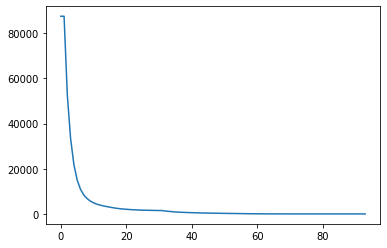

In [730]:
nytimes_article_diffs['version'].value_counts().sort_index().plot()

In [733]:
nytimes_article_diffs.shape

(395643, 11)

In [732]:
nytimes_article_diffs.loc[lambda df: df['num_versions'] < 20].shape

(318997, 11)

# Do we have to be worried about sentences that change substantially?

In [629]:
## it's a new sentence if old_len - num_removed < num_added?

In [612]:
word_stats_df = pd.DataFrame(word_stats_df)

In [620]:
word_stats_df.head(1)

,num_words_removed,num_words_added,len_old_sent,len_new_sent,version_nums,s_old,s_new,sent_par
0,3,0,7,4,"(0, 1)","[{'text': 'MOGADISHU', 'tag': ' '}, {'text': '...","[{'text': 'MOGADISHU', 'tag': ' '}, {'text': '...","(MOGADISHU, Somalia (AP) —, MOGADISHU, Somalia —)"


In [631]:
word_stats_df['added_ratio'] = (word_stats_df
 .apply(lambda x:  x['num_words_added'] / (x['len_old_sent'] - x['num_words_removed'] ), axis=1)
)

In [644]:
t = word_stats_df.loc[lambda df: df['added_ratio'] > .3]

In [680]:
s_o, s_n = t.iloc[-1][['s_old', 's_new']]
for x in up.html_compare_sentences(s_o, s_n):
    display(HTML(x))

In [668]:
def get_char_ratio(row):
    s_old, s_new = row[['s_old', 's_new']]
    base_items = list(filter(lambda x: x['text'].strip() != '' and x['tag'] == ' ', s_old))
    len_base_chars = sum(map(lambda x: len(x['text']), base_items))
    
    added_items = list(filter(lambda x: x['tag'] == '+' and x['text'].strip() != '' , s_new))
    len_added_chars = sum(map(lambda x: len(x['text']), added_items))
    
    return len_added_chars / len_base_chars

In [673]:
word_stats_df['char_ratio'] = word_stats_df.apply(get_char_ratio, axis=1)

In [681]:
s_o, s_n = word_stats_df.loc[lambda df: df['char_ratio'] > .3].iloc[0][['s_old', 's_new']]
for x in up.html_compare_sentences(s_o, s_n):
    display(HTML(x))

In [690]:
s_o, s_n = word_stats_df.loc[lambda df: df['char_ratio'] > 1.2].iloc[0][['s_old', 's_new']]
for x in up.html_compare_sentences(s_o, s_n):
    display(HTML(x))

In [691]:
## no, we don't

# What #-new-sentences cutoff should we use for determining new article?

In [698]:
## can we use sentences-embeddings to see when a sentence is factually new compared with a removed sentence? 

In [692]:
sentence_stats_df = pd.DataFrame(sentence_stats_df)

In [145]:
display(HTML(up.html_compare_articles(*sentence_stats_df.iloc[0][['vars_old', 'vars_new']])))

Old Version,New Version
"PARIS — In the hours after the attacks in Brussels on Tuesday, many countries quickly added soldiers and police officers at airports and rail and subway stations, hoping to reassure passengers and deter other potential terrorists.","PARIS — In the hours after the attacks in Brussels on Tuesday, many countries quickly added soldiers and police officers at airports and rail and subway stations, hoping to reassure passengers and deter other potential terrorists."
"But despite a series of episodes in recent years that have targeted transportation hubs worldwide, security experts predict that the latest attacks will revive — but not resolve — a thorny public debate about the benefits of ever more costly and intensive screening systems meant to identify terrorists among the millions of people who travel each day.","But despite a series of episodes in recent years that have targeted transportation hubs worldwide, security experts predict that the latest attacks will revive — but not resolve — a thorny public debate about the benefits of ever more costly and intensive screening systems meant to identify terrorists among the millions of people who travel each day."
"“It’s always about achieving a balance between what is achievable and what is practical,” said Norman Shanks, a consultant and former manager of airport security at Heathrow Airport near London.","“It’s always about achieving a balance between what is achievable and what is practical,” said Norman Shanks, a consultant and former manager of airport security at Heathrow Airport near London."
"Since the Sept. 11, 2001, attacks in the United States, travelers worldwide have grown accustomed to measures scrutinizing everything they carry with them into an airport, from the soles of their shoes to shampoo bottles, for potential weapons or traces of explosives.","Since the Sept. 11, 2001, attacks in the United States, travelers worldwide have grown accustomed to measures scrutinizing everything they carry with them into an airport, from the soles of their shoes to shampoo bottles, for potential weapons or traces of explosives."
"But such measures have mainly been focused on preventing terrorists from carrying out an attack aboard an aircraft, rather than an attack on the airport itself.","But such measures have mainly been focused on preventing terrorists from carrying out an attack aboard an aircraft, rather than an attack on the airport itself."
,"In the United States, the federal agency responsible for airport screening, the Transportation Security Administration — whose budget is $7.3 billion this year — spends much of that money on security screeners at checkpoints and on equipment that can detect bombs or banned items like knives."
,"But the responsibility for security in public areas of airports is shared by the local authorities and the T.S.A., leaving vulnerabilities in the public areas where passengers check in and drop off their bags."
,"“We really need to re-examine how we allocate our resources,” said John C. Cohen, a former acting under secretary for intelligence and analysis at the Department of Homeland Security and now a professor at the Faith-Based Community Security Program at Rutgers University."
"As the dual explosions at Brussels Airport made vividly clear , fully securing the public areas of a large , sprawling site like an airport is a daunting task .","But as the dual explosions at Brussels Airport made vividly clear , fully securing the public areas of a large , sprawling site like an airport is a daunting task ."
The attack on Tuesday was not the first time that terrorists had targeted the easily accessible areas of a major European airport.,The attack on Tuesday was not the first time that terrorists had targeted the easily accessible areas of a major European airport.


In [147]:
sentence_stats_df['added_sents_ratio'] = sentence_stats_df.pipe(lambda df: df['num_added_sents'] / df['len_new_doc'])

In [148]:
ao, an = (sentence_stats_df
 .loc[lambda df: df['added_sents_ratio'] < .5]
 .sort_values('added_sents_ratio', ascending=False)
 .iloc[0]
 [['vars_old', 'vars_new']]
)

In [149]:
display(HTML(up.html_compare_articles(ao, an)))

Old Version,New Version
"SHANGHAI — China’s growth streak has lasted for decades, surviving the crackdown at Tiananmen Square, the global financial crisis and the trade war with the United States.","SHANGHAI — China’s growth streak has lasted for decades, surviving the crackdown at Tiananmen Square, the global financial crisis and the trade war with the United States."
"But it might not endure the coronavirus epidemic, making it nearly impossible for the rest of the world to escape a slowdown.","But it might not endure the coronavirus epidemic, making it nearly impossible for the rest of the world to escape a slowdown."
"The damage was widespread in the official numbers on Monday, the first significant batch of government data since China’s vast containment efforts brought the country to a standstill.","The damage was widespread in the official numbers on Monday, the first significant batch of government data since China’s vast containment efforts brought the country to a standstill."
"Industrial production, retail sales and investment all posted record double-digit drops for the first two months of the year, compared with the same period in 2019.","Industrial production, retail sales and investment all posted record double-digit drops for the first two months of the year, compared with the same period in 2019."
The weakness raises the possibility that the entire Chinese economy may have shrunk in the first quarter of this year.,The weakness raises the possibility that the entire Chinese economy may have shrunk in the first quarter of this year.
"It would be the first contraction since 1976, when China was hit by the devastating Tangshan earthquake as well as the tumult from the death of Mao, whose Cultural Revolution threw the economy into disarray for a decade.","It would be the first contraction since 1976, when China was hit by the devastating Tangshan earthquake as well as the tumult from the death of Mao, whose Cultural Revolution threw the economy into disarray for a decade."
The knock-on effects for the world are significant.,The knock-on effects for the world are significant.
"China’s factories rely on oil and other commodities from countries like Angola, Sierra Leone and Chile.","China’s factories rely on oil and other commodities from countries like Angola, Sierra Leone and Chile."
"Its shoppers love Apple iPhones, Chevrolet cars and Starbucks coffees.","Its shoppers love Apple iPhones, Chevrolet cars and Starbucks coffees."
"Its construction of new buildings, roads and rail lines depends on steel often made from iron ore mined in Brazil or Australia.","Its construction of new buildings, roads and rail lines depends on steel often made from iron ore mined in Brazil or Australia."


In [150]:
(sentence_stats_df.loc[lambda df: df['added_sents_ratio'] < .5]).shape

(8295, 10)

In [151]:
sentence_stats_df.shape

(8836, 10)

In [152]:
one_sentence_additions = sentence_stats_df.loc[lambda df: df['num_added_sents'] == 1]

In [225]:
vars_old, vars_new = one_sentence_additions.iloc[21][['vars_old', 'vars_new']]

In [226]:
display(HTML(up.html_compare_articles(vars_old, vars_new)))

Old Version,New Version
WASHINGTON —,"WASHINGTON — A federal report released on Tuesday found the Trump administration set a rock - bottom price on the damages done by greenhouse gas emissions , enabling the government to justify the costs of repealing or weakening dozens of climate change regulations ."
"A federal report expected to be released Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.","The report by the Government Accountability Office, Congress’s nonpartisan investigative arm, said the Trump administration estimated the harm that global warming will cause future generations to be seven times lower than previous federal estimates."
"The report by the Government Accountability Office, Congress’s nonpartisan investigative arm, said the Trump administration estimated the harm that global warming will cause future generations to be seven times lower than previous federal estimates.","Reducing that metric, known as the “social cost of carbon,” has helped the administration massage cost-benefit analyses, particularly for rules that allow power plants and automobiles to emit more planet-warming carbon dioxide."
"Reducing that metric, known as the “social cost of carbon,” has helped the administration massage cost-benefit analyses, particularly for rules that allow power plants and automobiles to emit more planet-warming carbon dioxide.",Critics described the Trump administration’s move as turning a deliberate blind eye to the dangers of climate change.
Critics described the Trump administration’s move as turning a deliberate blind eye to the dangers of climate change.,"Some critics likened it to President Trump downplaying the risks of the coronavirus, hoping it would “go away” but instead leaving the country unprepared for the pandemic."
"Some critics likened it to President Trump downplaying the risks of the coronavirus, hoping it would “go away” but instead leaving the country unprepared for the pandemic.",“Climate change is a massive threat to our economy.
“Climate change is a massive threat to our economy.,"That threat will only grow in years to come, even if we take the action necessary to avoid the worst effects of climate change,” said Senator Sheldon Whitehouse of Rhode Island, one of eight Democrats who requested the review."
"That threat will only grow in years to come, even if we take the action necessary to avoid the worst effects of climate change,” said Senator Sheldon Whitehouse of Rhode Island, one of eight Democrats who requested the review.",The White House did not respond to a request for comment on the report.
The White House did not respond to a request on Monday for comment on the report.,"Every ton of carbon dioxide released into the atmosphere imposes a cost on the economy, whether from damage to infrastructure from sea level rise and heat waves or harm to public health."
"Every ton of carbon dioxide released into the atmosphere imposes a cost on the economy, whether from damage to infrastructure from sea level rise and heat waves or harm to public health.",But calculating the price of that damage has been economically challenging and politically contentious.


In [227]:
one_sentence_additions.iloc[21]

num_added_sents                                                      1
len_new_doc                                                         30
num_removed_sents                                                    2
len_old_doc                                                         30
num_changed_sents                                                    1
version_nums                                                    (0, 1)
a_id                                                           1972695
vars_old             [{'text': 'WASHINGTON —', 'tag': '-'}, {'text'...
vars_new             [{'text': 'WASHINGTON — A federal report relea...
added_sents_ratio                                            0.0333333
Name: 230, dtype: object

In [228]:
a1 = sample_diffs_by_article.loc[1972695].loc[lambda df: df['version'] == 0]['text'].iloc[0]
a2 = sample_diffs_by_article.loc[1972695].loc[lambda df: df['version'] == 1]['text'].iloc[0]
a1_sents = up.split_sents(a1)
a2_sents = up.split_sents(a2)

diffs = list(difflib.ndiff(a1_sents, a2_sents))

In [246]:
datelines = nytimes_article_diffs['text'].head(1000).str.split('—').str.get(0)

In [253]:
datelines.loc[lambda s: s.str.split().str.len() < 7].value_counts()

WASHINGTON                   61
TAMPA, Fla.                  55
NEW ORLEANS                  50
KABUL, Afghanistan           46
BEIRUT, Lebanon              35
                             ..
LUANDA, Angola (Reuters)      1
BERLIN (AP)                   1
MERCHTEM, Belgium             1
AMMAN, JORDAN                 1
MERCHTEM, BELGIUM             1
Name: text, Length: 96, dtype: int64

In [238]:
list(map(lambda x: x.text, up.get_nlp()(a1.split('</p><p>')[0]).sents))

['WASHINGTON —',
 'A federal report expected to be released Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.']

In [239]:
list(map(lambda x: x.text, up.get_nlp()(a2.split('</p><p>')[0]).sents))

['WASHINGTON — A federal report released on Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.']

In [230]:
a1_sents

['WASHINGTON —',
 'A federal report expected to be released Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.',
 'The report by the Government Accountability Office, Congress’s nonpartisan investigative arm, said the Trump administration estimated the harm that global warming will cause future generations to be seven times lower than previous federal estimates.',
 'Reducing that metric, known as the “social cost of carbon,” has helped the administration massage cost-benefit analyses, particularly for rules that allow power plants and automobiles to emit more planet-warming carbon dioxide.',
 'Critics described the Trump administration’s move as turning a deliberate blind eye to the dangers of climate change.',
 'Some critics likened it to President Trump downplaying the risks of the coronavirus, hoping it would “go aw

In [231]:
a2_sents

['WASHINGTON — A federal report released on Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.',
 'The report by the Government Accountability Office, Congress’s nonpartisan investigative arm, said the Trump administration estimated the harm that global warming will cause future generations to be seven times lower than previous federal estimates.',
 'Reducing that metric, known as the “social cost of carbon,” has helped the administration massage cost-benefit analyses, particularly for rules that allow power plants and automobiles to emit more planet-warming carbon dioxide.',
 'Critics described the Trump administration’s move as turning a deliberate blind eye to the dangers of climate change.',
 'Some critics likened it to President Trump downplaying the risks of the coronavirus, hoping it would “go away” but instead 

In [229]:
list(diffs)

['- WASHINGTON —',
 '- A federal report expected to be released Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.',
 '?  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n',
 '+ WASHINGTON — A federal report released on Tuesday found the Trump administration set a rock-bottom price on the damages done by greenhouse gas emissions, enabling the government to justify the costs of repealing or weakening dozens of climate change regulations.',
 '? + ^^^^^ +++++++++++++++++++++++++++++++++++\n',
 '  The report by the Government Accountability Office, Congress’s nonpartisan investigative arm, said the Trump administration estimated the harm that global warming will cause future generations to be seven times lower than previous federal estimates.',
 '  Reducing that metric, known as the “social cost of carbon,” has helped the adminis

In [224]:
display(HTML(up.html_compare_articles(*up.get_sentence_diff(a1, a2))))

Old Version,New Version
"WASHINGTON — A new figure has swept through the West Wing lately, a man with silver hair combed back across his head, rimless glasses perched on his nose, a white handkerchief tucked neatly into his suit pocket, a taste for legal pugilism and an uncertain role in a building confronted by a host of political and legal threats.","WASHINGTON — A new figure has swept through the West Wing lately, a man with silver hair combed back across his head, rimless glasses perched on his nose, a white handkerchief tucked neatly into his suit pocket, a taste for legal pugilism and an uncertain role in a building confronted by a host of political and legal threats."
"Marc E. Kasowitz, a New York civil litigator who represented President Trump for 15 years in business and boasts of being called the toughest lawyer on Wall Street, has suddenly become the field marshal for a White House under siege.","Marc E. Kasowitz, a New York civil litigator who represented President Trump for 15 years in business and boasts of being called the toughest lawyer on Wall Street, has suddenly become the field marshal for a White House under siege."
"He is a personal lawyer for the president, not a government employee, but he has been talking about establishing an office in the White House complex where he can run his legal defense.","He is a personal lawyer for the president, not a government employee, but he has been talking about establishing an office in the White House complex where he can run his legal defense."
His visits to the White House have raised questions about the blurry line between public and private interests for a president facing legal issues.,His visits to the White House have raised questions about the blurry line between public and private interests for a president facing legal issues.
"Mr. Kasowitz in recent days has advised White House aides to discuss the inquiry into Russia’s interference in last year’s election as little as possible, two people involved said.","Mr. Kasowitz in recent days has advised White House aides to discuss the inquiry into Russia’s interference in last year’s election as little as possible, two people involved said."
"He told aides gathered in one meeting who had asked whether it was time to hire private lawyers that it was not yet necessary, according to another person with direct knowledge.","He told aides gathered in one meeting who had asked whether it was time to hire private lawyers that it was not yet necessary, according to another person with direct knowledge."
"Such conversations between a private lawyer for the president and the government employees who work for his client are highly unusual , according to veterans of previous White Houses .","Such conversations between a private lawyer for the president and the government employees who work for his client are highly unusual , according to veterans of previous administrations ."
"Mr. Kasowitz bypassed the White House Counsel’s Office in having these discussions, according to one person familiar with the talks, who like others requested anonymity to discuss internal matters.","Mr. Kasowitz bypassed the White House Counsel’s Office in having these discussions, according to one person familiar with the talks, who like others requested anonymity to discuss internal matters."
And concerns about Mr. Kasowitz’s role led at least two prominent Washington lawyers to turn down offers to join the White House staff.,And concerns about Mr. Kasowitz’s role led at least two prominent Washington lawyers to turn down offers to join the White House staff.
"“The president’s private lawyer is representing only his interests, not the interests of the United States government or the individual interests of the White House staff,” said Robert F. Bauer, who was White House counsel under President Barack Obama.","“The president’s private lawyer is representing only his interests, not the interests of the United States government or the individual inter

## Parse out corrections?

In [ ]:
## todo:
## 1. run sentence-stats on the entire NYTimes dataset
## 2. dump "eligible versions" mapping
## 3. of eligible versions, start looking at:
##     a. number of entities in additions
##     b. number of quotes in additions
##     c. number of events in additions
##     d. discourse pattern in additions

## question-asking

In [ ]:
sample_diffs['joint_key'] = (sample_diffs
 .pipe(lambda df: df['article_id'].astype(str) + '-' + df['version'].astype(str))
)

In [542]:
sample_diffs_by_joint = sample_diffs.set_index('joint_key')

In [ ]:
a1, a2 = a_by_version.loc[6]['text']
vars_old, vars_new = up.get_sentence_diff(a1, a2)

In [548]:
dup_keys = sample_diffs['joint_key'].value_counts().loc[lambda s: s >1 ].index

In [549]:
sample_diffs_duped = sample_diffs_by_joint.loc[dup_keys]

In [555]:
t = sample_diffs_duped.reset_index()

In [561]:
import itertools

In [570]:
t_sentence_stats = []
t_word_stats = []

for key in tqdm(dup_keys):
    grouped_duped_diffs = sample_diffs_duped.loc[key]
    num_in_group = range(len(grouped_duped_diffs))
    pairs = itertools.combinations(num_in_group, 2)
    for a1, a2 in pairs:

        vars_old, vars_new = up.get_sentence_diff(
            grouped_duped_diffs.iloc[a1]['text'],
            grouped_duped_diffs.iloc[a2]['text']
        )

        doc_changes = up.get_changes(vars_old, vars_new)
        sent_change_pairs = doc_changes['sentences']['changed_sent_pairs']

        t_sentence_stats.append({
            'num_added_sents': len(doc_changes['sentences']['added_sents']),
            'len_new_doc': len(doc_changes['docs']['new_doc']),
            'num_removed_sents': len(doc_changes['sentences']['removed_sents']),
            'len_old_doc':len(doc_changes['docs']['old_doc']),
            'num_changed_sents': len(doc_changes['sentences']['changed_sent_pairs'])
        })
        for sent_pair in doc_changes['sentences']['changed_sent_pairs']:
            s_old, s_new = up.get_word_diffs(*sent_pair)
            t_word_stats.append({
                'num_words_removed': sum(map(lambda x: x['tag'] == '-', s_old)),
                'num_words_added': sum(map(lambda x: x['tag'] == '+', s_new)),
                'len_old_sent': len(s_old),
                'len_new_sent': len(s_new)
            })

  0%|          | 0/133 [00:00<?, ?it/s]

In [406]:
display(HTML(up.html_compare_articles(vars_old, vars_new)))

Old Version,New Version
"BANGKOK — Radical Buddhist groups are preventing doctors from delivering assistance to areas of western Myanmar affected by communal violence , an international medical charity said Monday .","BANGKOK — Radical Buddhist groups are preventing doctors from delivering assistance to areas of western Myanmar affected by intense sectarian violence , an international medical charity said on Monday ."
"The group, Médecins Sans Frontières, one of the leading providers of medical assistance to people in Rakhine State, reported that many of its local staff members were afraid to work at refugee camps and medical centers where people displaced by the violence awaited treatment.",
,"The group, Doctors Without Borders, reported that many of its local staff members were afraid to work at refugee camps and medical centers in Rakhine State, where people injured in clashes need treatment for wounds from guns, knives, arrows and other weapons."
"“ I ’ve never experienced this degree of intolerance , ” Joe Belliveau , the operations manager in Myanmar for Médecins Sans Frontières , said by telephone .","“ I ’ve never experienced this degree of intolerance , ” Joe Belliveau , the operations manager for Doctors Without Borders , said by telephone ."
“What we really need is for people to understand that giving medical aid is not a political act.”,“What we really need is for people to understand that giving medical aid is not a political act.”
The difficulties facing international agencies in Rakhine underline the instability of the area — and the potential for further outbreaks of violence — despite the presence of thousands of soldiers and police officers.,
"Mr. Belliveau said that posters and pamphlets were being distributed in Sittwe, the largest city in Rakhine, threatening aid workers who treat Muslims.",
"Clashes late last month between Buddhists and Muslims left 89 people dead and displaced 35,000, according to the United Nations.",
"In recent days, aid workers have reported treating people for wounds from guns and other weapons, including knives and arrows.",
,"The violence dates to June, when long-simmering resentment toward Muslims, some of whom come from Bangladesh, erupted after Muslims were accused of the rape and murder of a Buddhist girl."


In [354]:
## prediction tasks:
## ----------------------------------------------------------------------

## p(new sentences | old document)
## p(removed sentences | old document)
## p(same sentences | old document)

## p(sentence updates | old document)

In [349]:
display(HTML('<span style="background-color:rgba(255,0,0,0.3)">Hello my <span style="background-color:rgba(255,0,0,0.3)">name</span> is Xaviar</span>'))

In [282]:
t = (large_article_df
 .head()['html']
#  .apply(clean_html)
 .iloc[2]
)

# What time period do we have?

In [37]:
ls ../data/

diffengine-diffs/
newssniffer-articles-unified-partial-text.csv.gz
nytimes-article-diffs-full.csv.gz


In [11]:
all_article_df = pd.read_csv('../data/newssniffer-articles-unified-partial-text.csv.gz')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
all_article_df['source'].value_counts()

bbc             1527626
guardian        1191850
nytimes          623511
independent      229951
rtcom            150514
washpo           111503
theintercept       1992
Name: source, dtype: int64

In [228]:
all_article_df = all_article_df.merge(
    version_counts_df.drop('source', axis=1).rename(columns={'version': 'num_versions'}),
    left_on='article_id', 
    right_on='article_id'
)

Text(0.5, 0, 'Published time')

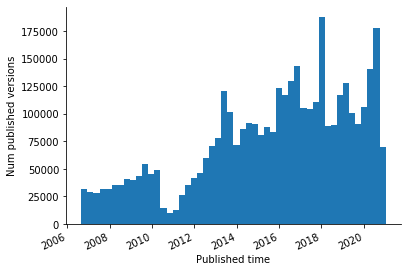

In [193]:
ax = all_article_df['time'].hist(bins=50)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation=25, horizontalalignment='right')
plt.ylabel('Num published versions')
plt.xlabel('Published time')

In [170]:
all_article_df['source'].value_counts()

bbc             1527626
guardian        1191850
nytimes          623511
independent      229951
rtcom            150514
washpo           111503
theintercept       1992
Name: source, dtype: int64

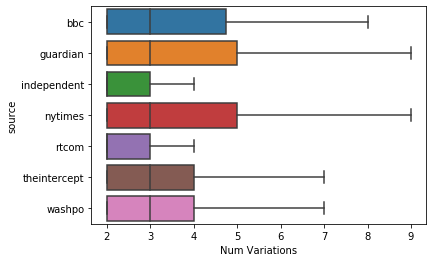

In [186]:
version_counts_df = (all_article_df
 .groupby(['source', 'article_id'])['version'].aggregate(len)
 .reset_index()
)

sns.boxplot(data=version_counts_df.loc[lambda df: df['version'] > 1], y='source', x='version', showfliers=False)
# ax.set_xlim(2, 12.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Num Variations');

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=14)

In [30]:
scores_df = pd.DataFrame({
'NYTimes':    [.85, .88, .91, .93],
'State-Level Bills':    [.58, .78, .76, .83],
'City Council\nMeeting Min.':    [.42, .64, .79, .77],
'Appeals\nCourt Cases':    [.63, .59, .58, .69],})

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

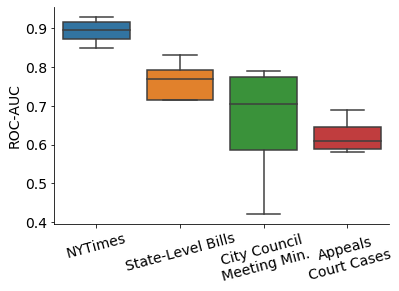

In [31]:
ax = sns.boxplot(data=scores_df.unstack().reset_index(), x='level_0', y=0, showfliers=False)
plt.ylabel('ROC-AUC')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('')
plt.xticks(rotation=15, horizontalalignment='center')

# Try new Diff Scheme
## Sentence diffs -> words per sentence diffs -> letters per word diffs

In [ ]:
unique_article_ids = article_df['article_id'].drop_duplicates()
indexed_article_df = article_df.set_index('article_id')
for a_id in unique_article_ids:
    indexed_article_df.loc[a_id]

In [77]:
a1, a2 = indexed_article_df.loc[a_id]['text'].iloc[[0, 1]]

## Filter out common phrases

In [234]:
from collections import defaultdict

sentence_counts = defaultdict(int)
guardian_articles = article_df.loc[lambda df: df['source'] == 'nytimes']['text'].sample(2000)
for idx, a in tqdm(enumerate(guardian_articles), total=len(guardian_articles)):
    sents = split_sents(a, perform_filter=True)
    for s in sents:
        if idx < 500:
            sentence_counts[s] += 1
        if idx > 500:
            if s in sentence_counts:
                sentence_counts[s] += 1

  0%|          | 0/2000 [00:00<?, ?it/s]

In [238]:
nyt_sentences = pd.Series(sentence_counts).sort_values(ascending=False)

In [715]:
nyt_sentences.loc[lambda s: s > 200]

When you get to your seat and your hands are clean, use disinfecting wipes to clean the hard surfaces at your seat like the head and arm rest, the seatbelt buckle, the remote, screen, seat back pocket and the tray table.                                                                            414
If you’ve been exposed to the coronavirus or think you have, and have a fever or symptoms like a cough or difficulty breathing, call a doctor.                                                                                                                                                          413
If possible, choose a window seat.                                                                                                                                                                                                                                                                      413
Some of these symptoms overlap with those of the flu, making detection difficult, but runny noses an

# Sentence-Level Diff Styling

In [84]:
vars_new, vars_old = get_sentence_diff(a1, a2)
html_table = format_html_table(vars_new, vars_old)

In [90]:
display(HTML('\n'.join(html_table)))

Old Version,New Version
"A tough Texas judge has released all defendants before him, reportedly saying it was what voters wanted, a day after he lost his re-election bid.","A tough Texas judge has released a group of defendants, reportedly saying it was what voters wanted, a day after he lost his re-election bid."
"Republican Judge Glenn Devlin let seven juvenile defendants go on Wednesday - including some charged with violent crimes, according to local media.","Republican Judge Glenn Devlin let seven juvenile defendants go on Wednesday - including some charged with violent crimes, according to local media."
Witnesses said that before releasing the defendants he asked them if they planned to kill anybody.,Witnesses said that before releasing the defendants he asked them if they planned to kill anybody.
The American Civil Liberties Union (ACLU) is demanding an investigation.,The American Civil Liberties Union (ACLU) is demanding an investigation.
The Harris County District Attorney Kim Ogg has condemned the jurist's actions.,The Harris County District Attorney Kim Ogg has condemned the jurist's actions.
"She told the BBC in an emailed statement: ""We oppose the wholesale release of violent offenders at any age; this could endanger the public.","She told the BBC in an emailed statement: ""We oppose the wholesale release of violent offenders at any age; this could endanger the public."
"""",""""
"Public Defender Steve Halpert told ABC 13 that when Judge Devlin took the bench on Wednesday, he asked the juvenile defendants before him: ""If I release you, will you go out and murder anybody?""","Public Defender Steve Halpert told ABC 13 that when Judge Devlin took the bench on Wednesday, he asked the juvenile defendants before him: ""If I release you, will you go out and murder anybody?"""
"""If the juvenile said 'no,' they were released,"" Mr Halpert said.","""If the juvenile said 'no,' they were released,"" Mr Halpert said."
"""Judge Devlin would never normally ask that question of a juvenile.","""Judge Devlin would never normally ask that question of a juvenile."


In [209]:
large_article_df.loc[0]['url']

'https://www.newssniffer.co.uk/articles/688245/versions/1592624'

In [215]:
def clean_large_article_html(html):
    pass

In [222]:
t = large_article_df.loc[0]

In [224]:
t['url']

'https://www.newssniffer.co.uk/articles/688245/versions/1592624'

In [220]:
all_article_df

,version,title,time,text,article_url,source,article_id,num_versions
0,0,Frieze and Felix Turn Heads in Los Angeles,2019-02-20 00:32:07+00:00,Galleries participating in art fairs tend to j...,https://www.nytimes.com/2019/02/19/arts/design...,nytimes,1741157,3
1,1,Frieze and Felix Turn Heads in Los Angeles,2019-02-21 20:30:12+00:00,Galleries participating in art fairs tend to j...,https://www.nytimes.com/2019/02/19/arts/design...,nytimes,1741157,3
2,2,Frieze and Felix Turn Heads in Los Angeles,2019-02-26 13:24:07+00:00,Galleries participating in art fairs tend to j...,https://www.nytimes.com/2019/02/19/arts/design...,nytimes,1741157,3
3,0,Trump praises controversial pundit Candace Owe...,2018-05-09 18:05:07+00:00,Donald Trump tweeted praise for conservative Y...,https://www.theguardian.com/us-news/2018/may/0...,guardian,1598268,5
4,1,Trump praises controversial pundit Candace Owe...,2018-05-09 22:05:16+00:00,Donald Trump tweeted praise for conservative Y...,https://www.theguardian.com/us-news/2018/may/0...,guardian,1598268,5
...,...,...,...,...,...,...,...,...
3836942,0,Struggling London hospitals sending Covid pati...,2021-01-14 20:12:00+00:00,NaN,https://www.theguardian.com/society/2021/jan/1...,guardian,2058840,3
3836943,1,Struggling London hospitals sending Covid pati...,2021-01-14 20:44:00+00:00,NaN,https://www.theguardian.com/society/2021/jan/1...,guardian,2058840,3
3836944,2,Struggling London hospitals sending Covid pati...,2021-01-14 23:32:00+00:00,NaN,https://www.theguardian.com/society/2021/jan/1...,guardian,2058840,3
3836945,0,US officials warn ‘full resurgence’ of Covid i...,2021-01-16 02:06:00+00:00,NaN,https://www.theguardian.com/world/2021/jan/14/...,guardian,2058841,1


In [219]:
t.split('</a></p><p>')

['<p><a href="http://www.nytimes.com/2013/09/28/us/politics/senate-is-expected-to-approve-budget-bill.html">http://www.nytimes.com/2013/09/28/us/politics/senate-is-expected-to-approve-budget-bill.html',
 'Version 7 of 12.</p><p>WASHINGTON — The Senate on Friday overwhelmingly approved stopgap spending legislation to keep the federal government open without gutting President Obama’s health care law, setting up a weekend showdown with the House that will decide whether much of the government shuts down at midnight Monday.</p><p>The 54-to-44 vote for final passage followed a more critical moment when the Senate, in a bipartisan rebuke to Republican hard-liners, cut off debate on the legislation. The 79-to-19 vote included the top Republican leadership and easily exceeded the 60-vote threshold to break a filibuster.</p><p>The Senate then voted along party lines, 54 to 44, to strip out House Republican language that tied further funding of the government to defunding the health care law. Th

In [213]:
article_df['text'].iloc[0]

'Galleries participating in art fairs tend to judge their success by the numbers — not only profits from their sales but also how many new collectors they met who stay in touch. But for visitors, what matters most is less quantifiable: Was the fair experience memorable? And how was the art?</p><p>For many viewers reached by a reporter and photographer for The New York Times, the inaugural edition of Frieze Los Angeles and the upstart Felix LA art fair last weekend succeeded on those fronts, dispelling a longstanding notion of the city as a graveyard for art fairs and underscoring its vitality as an art center.</p><p>Frieze, set at Paramount Studios, commissioned artworks for the five-acre New York streetscape on the backlot and they helped to give the fair a different vibe, from Hannah Greely’s paintings of laundry on a clotheslines to Sarah Cain’s wall-to-window takeover of a classic brownstone apartment, including a brilliant stained-glass window.</p><p>In the big tent housing 70 gal